In [2]:
# adaptado de http://brandonrose.org/clustering#Tf-idf-and-document-similarity
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
import numpy as np
import re
import codecs
from sklearn import feature_extraction

In [3]:
os.chdir(r'C:\Users\vsaal\Documents\GitHub\DataScrapping-job-description')

In [4]:
f = open('catho_completo.txt', 'r', encoding='utf-8').readlines()

In [5]:
# Imprimo o primeiro termo do arquivo para garantir que foi aberto corretamente
print(f[0])

Data Scientist – Machine Learning & Real-Time Decision Processing



In [6]:
# Faco a leitura do arquivo contando com o separador ****_*

with open(r'catho_completo.txt', encoding = 'utf-8') as f:
    arquivo = f.readlines()
    # Removo os espacamentos \n
    arquivo = list(map(str.strip, arquivo))

a=0
indice = []
# Encontro quais as linhas com as quebras de descricoes
for valor in arquivo:
    if valor.strip() == '****_*':
        indice.append(a)
    a+=1
indice.insert(0,0)

texto=[]
descricoes=[]
# Separo as descricoes entre sublistas
for valor in range(0, len(indice)-1):
    texto = ' '.join(arquivo[indice[valor]:indice[valor+1]])
    descricoes.append(texto)

In [7]:
# Imprimo os primeiros 200 termos da primeira descrição para ver a correta abertura do arquivo
descricoes[0][:200]

'Data Scientist – Machine Learning & Real-Time Decision Processing Valassis Digital is a leader in online advertising technology. We process over 12 trillion calculations daily to analyze and decide on'

In [35]:
extra_words = ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha',
               'wo', 'would', 'abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv',
               'themselv', 'veri', 'whi', 'yourselv', 'new', 'etc']
Stopwords = set(nltk.corpus.stopwords.words('english') + list(punctuation) + extra_words)

In [36]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

In [37]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [38]:
# Below I use my stemming/tokenizing and tokenizing functions to iterate 
# over the list of descriptions to create two vocabularies: one stemmed and one only tokenized.

#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in descricoes:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [39]:
# Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. 
# The benefit of this is it provides an efficient way to look up a stem and return a full token. 
# The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. 
# For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 3516798 items in vocab_frame


In [40]:
vocab_frame.head()

,words
data,data
scientist,scientist
machin,machine
learn,learning
real-tim,real-time


Tf-idf and document similarity


Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the synopses list into a tf-idf matrix.

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of descriptions)
min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See n-grams

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words=Stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(descricoes) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

Wall time: 1min 19s
(7287, 290)


In [44]:
# terms is just a list of the features used in the tf-idf matrix. This is a vocabulary
%time terms = tfidf_vectorizer.get_feature_names()

Wall time: 998 µs


dist is defined as 1 - the cosine similarity of each document. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each synopsis among the synopses). Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.

Note that with dist it is possible to evaluate the similarity of any two or more synopses.

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

In [46]:
dist = 1 - cosine_similarity(tfidf_matrix)

K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose k-means. K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima.

In [47]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 42.6 s



I use joblib.dump to pickle the model, once it has converged and to reload the model/reassign the labels as the clusters.

In [48]:
from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [49]:
nomes_clusters = {'synopsis': descricoes, 'cluster': clusters}

frame = pd.DataFrame(nomes_clusters, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [50]:
frame['cluster'].value_counts() #number of descriptions per cluster (clusters from 0 to 4)

2    3649
0    1226
1    1211
4     803
3     398
Name: cluster, dtype: int64

In [52]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % (i+1), end='\n')
    
    for ind in km.cluster_centers_.argsort()[:, ::-1][i, :5]: #replace 6 with n words per cluster
        print(terms[ind])
    print()

Top terms per cluster:

Cluster 1 words:
algorithm
build
code
engin
system

Cluster 2 words:
technolog
intellig
solut
innov
analysi

Cluster 3 words:
busi
model
scientist
data scientist
opportun

Cluster 4 words:
knowledg
platform
secur
product
tensorflow

Cluster 5 words:
ai
engin
includ
perform
network



### Multidimensional scaling

Here is some code to convert the dist matrix into a 2-dimensional array using multidimensional scaling. I won't pretend I know a ton about MDS, but it was useful for this purpose. Another option would be to use principal component analysis.

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

Wall time: 1h 43min 10s




### Visualizing document clusters
In this section, I demonstrate how you can visualize the document clustering output using matplotlib and mpld3 (a matplotlib wrapper for D3.js).

First I define some dictionaries for going from cluster number to color and to cluster name. I based the cluster names off the words that were closest to each cluster centroid.

In [25]:

#set up colors per clusters using a dict
cluster_colors = {0: 'red', 1: 'blue', 2: 'yellow', 3: 'pink', 4: 'purple'}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 
                 1: 'Cluster 2', 
                 2: 'Cluster 3', 
                 3: 'Cluster 4', 
                 4: 'Cluster 5'}

Next, I plot the labeled observations (descriptions) colored by cluster using matplotlib. I won't get into too much detail about the matplotlib plot, but I tried to provide some helpful commenting.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


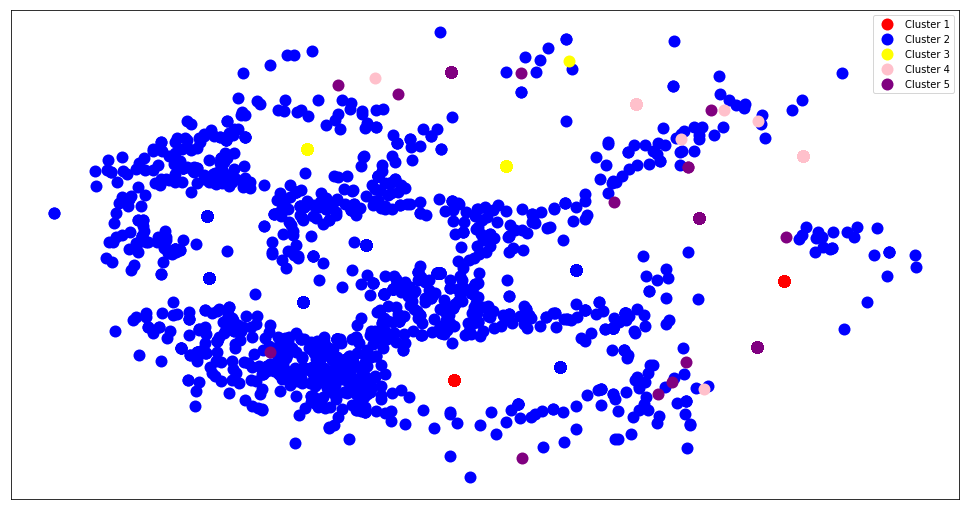

In [26]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

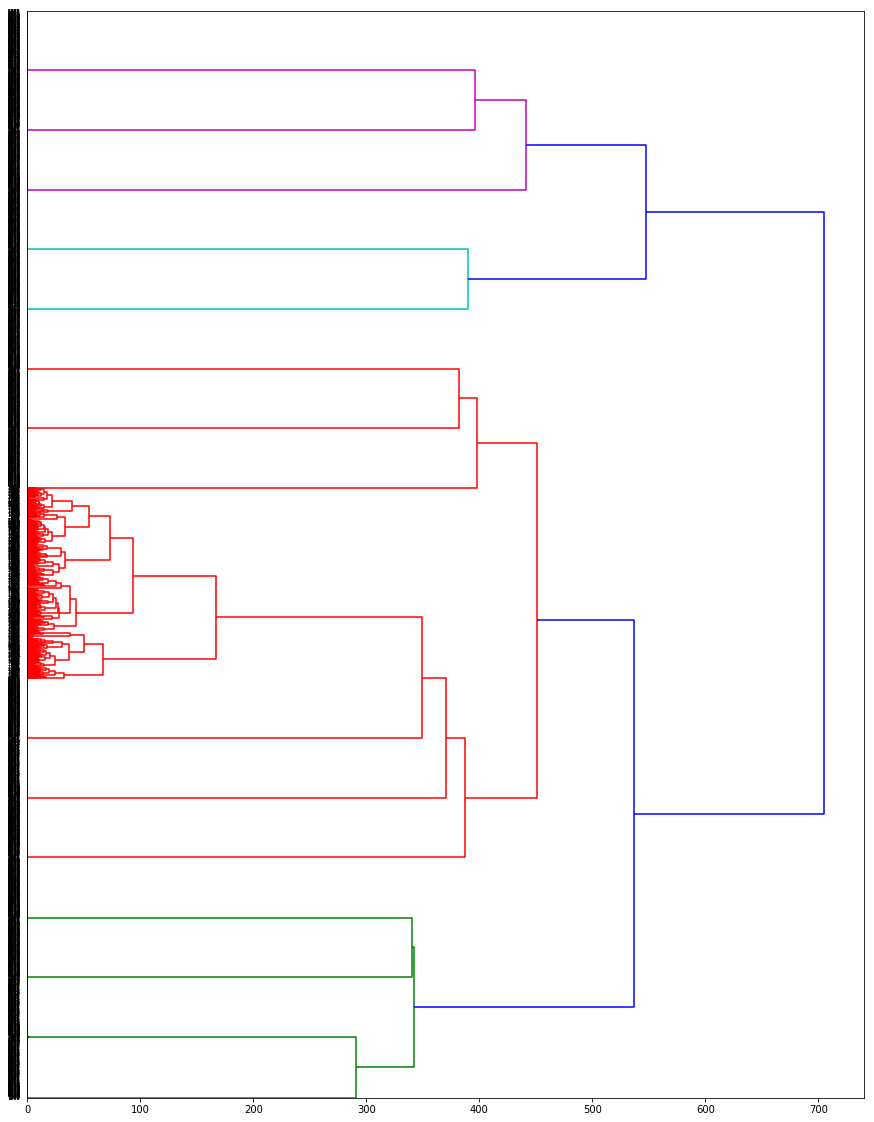

In [27]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right");

# plt.tick_params(\
#     axis= 'x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom='off',      # ticks along the bottom edge are off
#     top='off',         # ticks along the top edge are off
#     labelbottom='off')

# plt.tight_layout() #show plot with tight layout